# Solving boundary value problems (BVP) and eigenvalue problems (EVP)

**Table of contents**<a id='toc0_'></a>    
1. [BVP in Cartesian coordinates (Laplace equation)](#toc1_)    
2. [BVP on a disc (steady MHD pipe flow)](#toc2_)    
3. [EVP on a disc (oscillations of circular membrane)](#toc3_)    
3.1. [Implementing polar symmetry](#toc3_1_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In this notebook, we show how to solve the linear boundary value problems and the linear eigenvalue problems using Trispectral and SciPy.

In [1]:
import os.path
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
import trispectral as ts

In [2]:
cwd = os.path.abspath("")

plt.style.use(os.path.join(cwd, "../misc/mpl_styles/main.mplstyle"))

## 1. <a id='toc1_'></a>[BVP in Cartesian coordinates (Laplace equation)](#toc0_)

Consider the following 2D Laplace equation:

$\nabla^2 u = 0$, for $0\le x \le a$ and $0\le y \le b$,

with the boundary conditions,

$u(0, y) = u(x, 0) = 0$,

$u(a, y) = \sin{(\omega y)} / \sin{(\omega b)}$,

$u(x, b) = \sin{(\omega x)} / \sin{(\omega a)}$.

First, we define the parameters of the problem and the computational grid.

In [3]:
omega = 4.
a = 2.
b = 2.

In [4]:
nx = 61
ny = 61

grid = ts.Grid.from_bounds(
    [0, a, nx], [0, b, ny], discs=["chebyshev"] * 2
)

x, y = grid

Before applying the boundary conditions, the left-hand side and the right-hand side matrices of this problem can be constructed as follows. 

In [5]:
lhs = ts.scalar_laplacian_operator(grid)
rhs = np.zeros(nx * ny)

The `boundary_indices` method of the `Grid` object allows us to immediately obtain the indices of the boundary nodes as they appear in the grid.

In [6]:
bnds = grid.boundary_indices()

xmin, xmax = bnds[0]
ymin, ymax = bnds[1]

In 2D Cartesian geometry, `grid.boundary_indices()` returns the Python list `[(xmin, xmax), (ymin, ymax)]`, where `xmin`, `xmax`, `ymin`, and `ymax` are the NumPy arrays containing the indices of respective boundaries.

We then replace the lines of `lhs` and `rhs` with indices `xmin`, `xmax`, `ymin`, and `ymax` with explicit boundary condition expressions. For example, the line

```python
lhs[xmin] = np.identity(nx * ny)[xmin]
```

results into `ny` linear equations implementing $u(0, y) = 0$ (note that `rhs` is already 0). However, in the case of inhomogeneous Dirichlet conditions, we have to explicitly replace the entries of `rhs`.

In [7]:
lhs[xmin] = np.identity(nx * ny)[xmin] # rhs already 0 at xmin

lhs[xmax] = np.identity(nx * ny)[xmax]
rhs[xmax] = np.sin(omega * y[xmax]) / np.sin(omega * b)

lhs[ymin] = np.identity(nx * ny)[ymin] # rhs already 0 at ymin

lhs[ymax] = np.identity(nx * ny)[ymax]
rhs[ymax] = np.sin(omega * x[ymax]) / np.sin(omega * a)

We then solve the BVP using SciPy's `linalg.solve` and plot the solution.

In [8]:
u = la.solve(lhs, rhs)

In [ ]:
import scipy.linalg
scipy.linalg.solve()

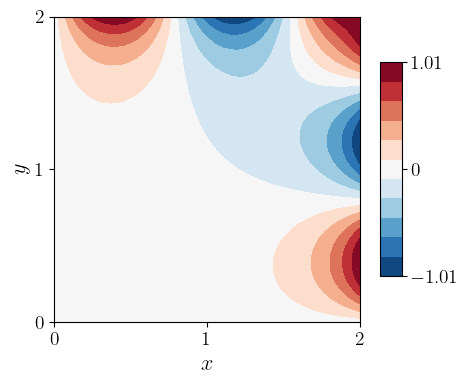

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(5, 4), tight_layout=True)

ax.set_aspect(b / a)

ax.set_xlim(0, a)
ax.set_ylim(0, b)

ax.set_xlabel("$x$")
ax.set_ylabel("$y$")

c = ax.contourf(
    x.reshape(nx, ny, order="F"),
    y.reshape(nx, ny, order="F"),
    u.reshape(nx, ny, order="F"),
    levels=np.linspace(np.min(u), np.max(u), 12),
    cmap=plt.get_cmap("RdBu_r"),
)

cbar = plt.colorbar(
    c,
    ax=ax,
    ticks=[np.min(u), 0, np.max(u)],
    location="right",
    shrink=0.7,
    aspect=10,
)
cbar.ax.set_yticklabels(
    [
        f"${np.min(u): .2f}$",
        0,
        f"${np.max(u): .2f}$"
    ]
)

ax.set_xticks(np.arange(0, a + 1, 1))
ax.set_yticks(np.arange(0, b + 1, 1));

# plt.savefig("ex_3.pdf");

## 2. <a id='toc2_'></a>[BVP on a disc (steady MHD pipe flow)](#toc0_)

$\nabla^2 U + Ha^2 \left( \cos{\theta}\frac{\partial}{\partial r} - \frac{\sin{\theta}}{r}\frac{\partial}{\partial \theta}\right)M = Re K$,

$\nabla^2 M + \left( \cos{\theta}\frac{\partial}{\partial r} - \frac{\sin{\theta}}{r}\frac{\partial}{\partial \theta}\right)U = 0$.

In [10]:
k = -1. # Re·K
Ha = 50. # the Hartmann number
conductance = 0
wavevector = [0, None], [1, None], 0

In [11]:
nphi, nr = 64, 64

grid = ts.Grid.polar(nphi, nr)

phi, r = grid[:, grid[1] > 0]

In [12]:
magnetic_field = np.concatenate(
    [-np.sin(phi), np.cos(phi), np.zeros(nphi * nr)]
)

In [13]:
laplacian = ts.scalar_laplacian_operator(grid, parity=1)
directional_derivative = ts.directional_derivative_operator(
    grid, a=magnetic_field, wavevector=wavevector
).real[2 * nphi * nr :, 2 * nphi * nr :] # extract z component

In [14]:
lhs = np.vstack(
    [
        np.hstack([laplacian, Ha**2 * directional_derivative]),
        np.hstack([directional_derivative, laplacian]),
    ]
)

rhs = np.zeros(2 * nphi * nr)
rhs[: nphi * nr] = k

In [15]:
bnd = grid.boundary_indices(axis=1)

In [16]:
O, I = np.zeros([nphi * nr, nphi * nr]), np.identity(nphi * nr)

lhs[bnd] = np.hstack([I[bnd], O[bnd]])
rhs[bnd] = 0

if conductance == 0: # M = 0
    lhs[bnd + nphi * nr] = np.hstack([O[bnd], I[bnd]])
else:
    d1r = ts.DifferentialMatrix(grid, axis=1)

    lhs[bnd + nphi * nr] = np.hstack(
        [O[bnd], d1r[bnd] + 1 / conductance * I[bnd]]
    )

In [17]:
U = la.solve(lhs, rhs)[: nphi * nr]

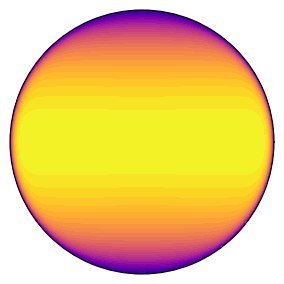

In [18]:
fig, ax = plt.subplots(
    1,
    1,
    figsize=(6, 3),
    subplot_kw={"projection": "polar"},
    tight_layout=True,
)

phi_m = phi.reshape(nphi, nr, order="F")
phi_m = np.vstack([phi_m, -phi_m[0]])
r_m = r.reshape(nphi, nr, order="F")
r_m = np.vstack([r_m, r_m[0]])
U_m = U.reshape(nphi, nr, order="F")
U_m = np.vstack([U_m, U_m[0]])

ax.grid(False)
ax.set_xticklabels([])
ax.set_yticklabels([])

ax.contourf(
    phi_m,
    r_m,
    U_m,
    levels=np.linspace(np.min(U_m), np.max(U_m), 31),
    cmap=plt.get_cmap("plasma"),
);

# plt.savefig("ex_4.pdf");

## 3. <a id='toc3_'></a>[EVP on a disc (oscillations of circular membrane)](#toc0_)

In [3]:
nphi, nr = 64, 64

grid = ts.Grid.polar(nphi, nr)

phi, r = grid[:, grid[1] > 0]

In [4]:
mat = ts.scalar_laplacian_operator(grid, parity=1)

In [5]:
rmax = grid.boundary_indices(axis=1)

mat[rmax] = -1e4 * np.identity(nr * nphi)[rmax]

In [6]:
lam, u = la.eig(-mat)

lam = np.sqrt(lam).real

argsort = lam.argsort()
lam, u = lam[argsort], u.real[:, argsort]

In [7]:
print(lam[:9] / lam[0])

[1.         1.59334051 1.59334051 2.13554879 2.13554879 2.29541727
 2.6530664  2.6530664  2.91729546]


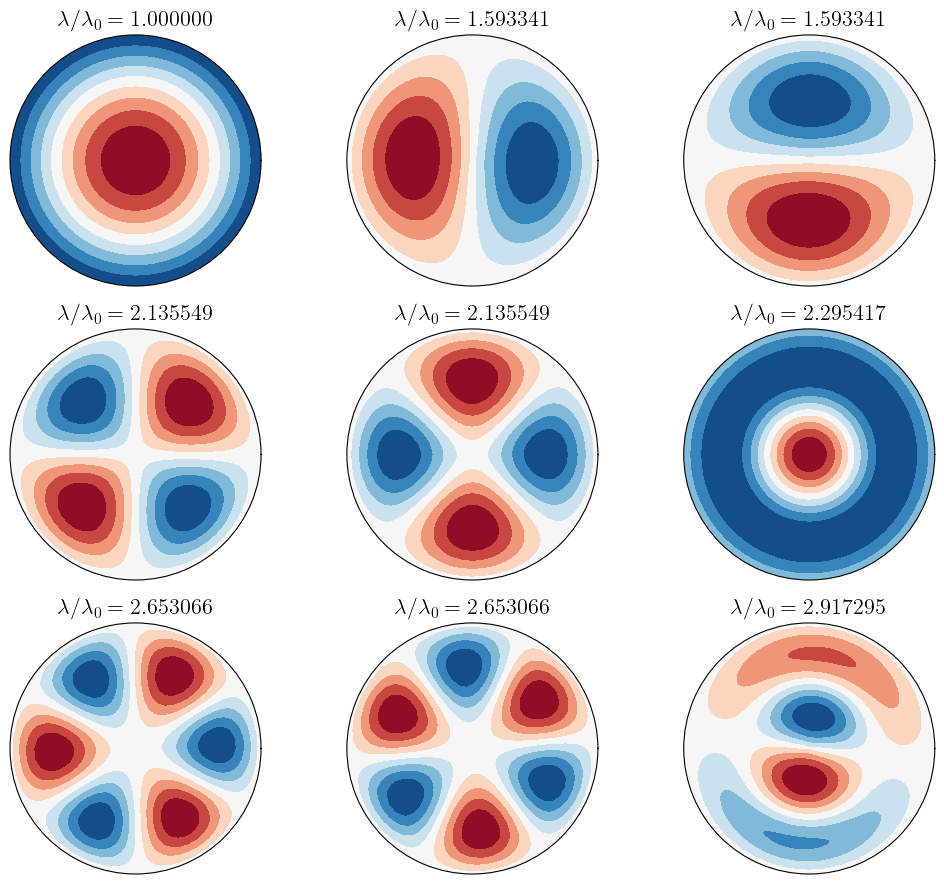

In [8]:
fig, ax = plt.subplots(
    3,
    3,
    figsize=(12, 9),
    subplot_kw={"projection": "polar"},
    tight_layout=True,
)
ax = ax.ravel()

phi_m = phi.reshape(nphi, nr, order="F")
phi_m = np.vstack([phi_m, -phi_m[0]])
r_m = r.reshape(nphi, nr, order="F")
r_m = np.vstack([r_m, r_m[0]])

for i, axis in enumerate(ax):
    axis.grid(False)
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    u_m = u[:, i].reshape(nphi, nr, order="F")
    u_m = np.vstack([u_m, u_m[0]])

    axis.contourf(
        phi_m,
        r_m,
        u_m,
        levels=np.linspace(np.min(u_m), np.max(u_m), 10),
        cmap=plt.get_cmap("RdBu_r"),
    )

    axis.set_title(f"$\\lambda / \\lambda_0 = {lam[i] / lam[0]: .6f}$")

    # plt.savefig("ex_5.pdf");

### 3.1. <a id='toc3_1_'></a>[Implementing polar symmetry](#toc0_)

In [9]:
symmetry = "pole"

We can reuse the grid from the previous example. However, the computational domain is now reduced to $] 0, 1] \times [ 0,\pi [$.

In [10]:
mat = ts.scalar_laplacian_operator(grid, symmetry=symmetry)

In [11]:
rmax = grid.boundary_indices(axis=1, symmetry=symmetry)

mat[rmax] = -1e4 * np.identity(nr * int(nphi / 2))[rmax]

In [12]:
lam, u = la.eig(-mat)

lam = np.sqrt(lam).real

argsort = lam.argsort()
lam, u = lam[argsort], u.real[:, argsort]

In [13]:
print(lam[:4] / lam[0])

[1.         2.13554879 2.13554879 2.29541727]


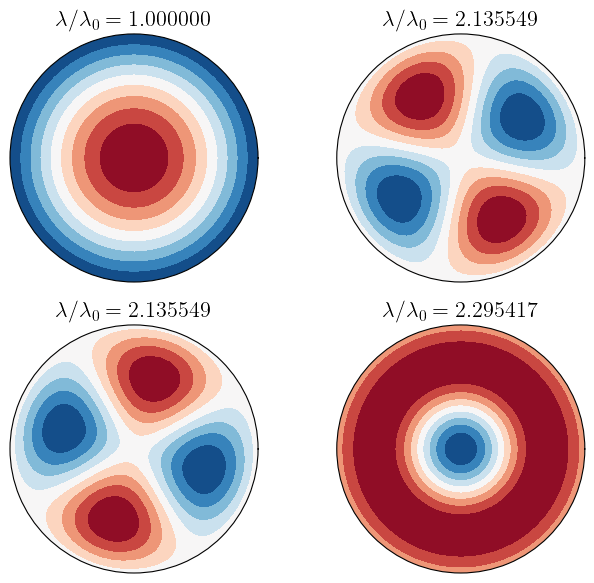

In [18]:
fig, ax = plt.subplots(
    2,
    2,
    figsize=(9, 6),
    subplot_kw={"projection": "polar"},
    tight_layout=True,
)
ax = ax.ravel()

phi, r = grid[:, grid[1] > 0]
phi_m = phi.reshape(nphi, nr, order="F")
phi_m = np.vstack([phi_m, -phi_m[0]])
r_m = r.reshape(nphi, nr, order="F")
r_m = np.vstack([r_m, r_m[0]])

p = 1 if symmetry == "pole" else -1

for i, axis in enumerate(ax):
    axis.grid(False)
    axis.set_xticklabels([])
    axis.set_yticklabels([])

    u_m = u[:, i].reshape(int(nphi / 2), nr, order="F")
    u_m = np.vstack([p * u_m, u_m])
    u_m = np.vstack([u_m, u_m[0]])

    axis.contourf(
        phi_m,
        r_m,
        u_m,
        levels=np.linspace(np.min(u_m), np.max(u_m), 10),
        cmap=plt.get_cmap("RdBu_r"),
    )

    axis.set_title(f"$\\lambda / \\lambda_0 = {lam[i] / lam[0]: .6f}$")

    # plt.savefig("ex_6.pdf");